In [1]:
import warnings
warnings.simplefilter(action="ignore", category=UserWarning)

import pandas as pd
import psycopg

db = psycopg.connect("dbname=next host=localhost port=5432 user=postgres password=postgres")

factions = pd.read_sql_query("select * from open_discourse.factions", db)
print(factions)

    id  abbreviation                                          full_name
0   -1     not found                                          not found
1    0           AfD                        Alternative für Deutschland
2    1           BHE      Block der Heimatvertriebenen und Entrechteten
3    2            BP                                       Bayernpartei
4    3         Grüne                              Bündnis 90/Die Grünen
5    4       CDU/CSU  Christlich Demokratische Union Deutschlands/Ch...
6    5            DA                  Demokratische Arbeitsgemeinschaft
7    6    DIE LINKE.                                         DIE LINKE.
8    7            DP                                    Deutsche Partei
9    8        DP/DBP             Deutsche Partei/Deutsche Partei Bayern
10   9        DP/FVP                  Deutsche Partei/Freie Volkspartei
11  10           DPB                             Deutsche Partei Bayern
12  11           DRP                              Deutsche Refor

In [2]:
speeches = pd.read_sql_query("select * from open_discourse.speeches limit 10", db)
print(speeches)

   id  session  electoral_term first_name last_name  politician_id  \
0   0        2               1               Köhler       11001150   
1   1        2               1               Arnold             -1   
2   2        2               1               Köhler       11001150   
3   3        2               1                Heuss             -1   
4   4        2               1               Köhler       11001150   
5   5        2               1                Heuss             -1   
6   6        3               1               köhler       11001150   
7   7        3               1             adenauer       11000009   
8   8        3               1               köhler       11001150   
9   9        4               1               köhler       11001150   

                                      speech_content  faction_id  \
0  Meine Damen und Herren! Ich eröffne die 2. Sit...          -1   
1    Der Bundesrat ist versammelt, Herr Präsident.\n          -1   
2  Ich danke für diese Er

In [37]:
speeches = pd.read_sql_query("""
    SELECT speech_content, factions.abbreviation as faction, electoral_term, date_part('year', date)::int as year
    FROM open_discourse.speeches
    JOIN open_discourse.factions ON factions.id = speeches.faction_id
    WHERE faction_id <> -1 AND faction_id <> 16
    AND date_part('year', date)::int >= 2018
    """, db)
print(speeches.shape)
print(speeches.head())

(39622, 4)
                                      speech_content     faction  \
0  \n\nFrau Präsidentin! Sehr verehrte Damen und ...       Grüne   
1  \n\nSehr geehrte Frau Barley, wir alle kennen ...     CDU/CSU   
2  \n\nSehr geehrte Frau Ministerin, in Deutschla...         AfD   
3  \n\nVielen Dank, Herr Präsident. – Frau Minist...         SPD   
4  \n\nFrau Ministerin, danke schön für den Beric...  DIE LINKE.   

   electoral_term  year  
0              19  2018  
1              19  2018  
2              19  2018  
3              19  2018  
4              19  2018  


In [1]:
import numpy as np
from sentence_transformers import SentenceTransformer
import torch
import umap

# model = SentenceTransformer("deutsche-telekom/gbert-large-paraphrase-euclidean") # Large model
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
print(f"Model loaded on {model.device}") # Device property doesn't work on 2.2.2

ModuleNotFoundError: No module named 'sentence_transformers'

In [39]:
# Calculate embeddings for each speech
embeddings = model.encode(speeches["speech_content"].values, convert_to_numpy=True)
print("Encoded!")

Encoded!


In [40]:
speech_indices_by_faction_and_year = speeches.groupby(["faction", "year"]).groups

embedding_averages = {
    faction_and_year: np.mean(embeddings[indices], axis=0)
    for faction_and_year, indices in speech_indices_by_faction_and_year.items()
}
print(embedding_averages.keys())

reduced_embeddings = umap.UMAP().fit_transform(list(embedding_averages.values()))
print(reduced_embeddings)

dict_keys([('AfD', 2018), ('AfD', 2019), ('AfD', 2020), ('AfD', 2021), ('AfD', 2022), ('CDU/CSU', 2018), ('CDU/CSU', 2019), ('CDU/CSU', 2020), ('CDU/CSU', 2021), ('CDU/CSU', 2022), ('DIE LINKE.', 2018), ('DIE LINKE.', 2019), ('DIE LINKE.', 2020), ('DIE LINKE.', 2021), ('DIE LINKE.', 2022), ('FDP', 2018), ('FDP', 2019), ('FDP', 2020), ('FDP', 2021), ('FDP', 2022), ('Grüne', 2018), ('Grüne', 2019), ('Grüne', 2020), ('Grüne', 2021), ('Grüne', 2022), ('SPD', 2018), ('SPD', 2019), ('SPD', 2020), ('SPD', 2021), ('SPD', 2022)])
[[ 8.947989   6.8634233]
 [ 9.082651   7.2987933]
 [ 8.964694   6.577037 ]
 [ 8.619042   7.066908 ]
 [ 9.064561   5.9580436]
 [11.262228   9.203364 ]
 [11.11751    9.587499 ]
 [11.783828   9.01787  ]
 [12.108774   8.832683 ]
 [13.272154   8.076985 ]
 [ 9.661822   6.962404 ]
 [ 9.526698   6.582972 ]
 [ 9.922502   6.274382 ]
 [10.441062   6.587478 ]
 [ 9.608896   5.792934 ]
 [10.111847   8.499026 ]
 [ 9.75857    8.168498 ]
 [11.11918    7.829951 ]
 [11.639595   7.6855755

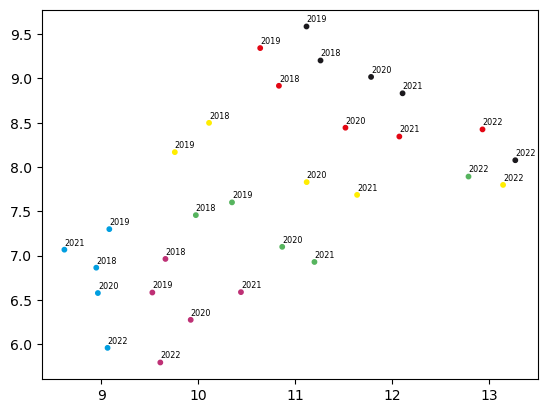

In [41]:
import matplotlib.pyplot as plt

colours = {
    "AfD": "#009ee0",
    "CDU/CSU": "#1b191d",
    "DIE LINKE.": "#be3075",
    "PDS": "#be3075",
    "FDP": "#ffed00",
    "Grüne": "#56b45e",
    "SPD": "#e30613"
}
keys = list(embedding_averages.keys())

scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=[colours[key[0]] for key in keys], s=10)

for i, embedding in enumerate(reduced_embeddings):
    plt.annotate(keys[i][1], (embedding[0], embedding[1] + 0.05), fontsize="xx-small")
#plt.legend(*scatter.legend_elements())
plt.show()

#import umap.plot

#faction_labels = pd.DataFrame({"factions": [f'{key[0]} {key[1]}' for key in embedding_averages.keys()]})["factions"]
#umap.plot.points(reducer, labels=faction_labels)

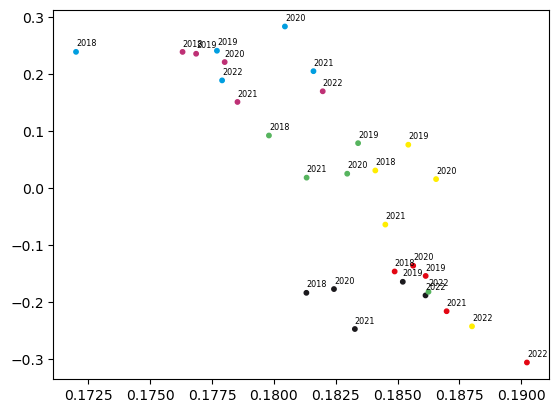

In [43]:
# Experiment with PCA instead of UMAP for dimensionality reduction

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(np.array(list(embedding_averages.values())).T)
reduced_embeddings = np.asarray(pca.components_).T

scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=[colours[key[0]] for key in keys], s=10)

for i, embedding in enumerate(reduced_embeddings):
    plt.annotate(keys[i][1], (embedding[0], embedding[1] + 0.01), fontsize="xx-small")
#plt.legend(*scatter.legend_elements())
plt.show()

In [44]:
speeches = pd.read_sql_query("""
    SELECT speech_content, factions.abbreviation as faction, electoral_term, date_part('year', date)::int as year
    FROM open_discourse.speeches
    JOIN open_discourse.factions ON factions.id = speeches.faction_id
    WHERE factions.abbreviation IN ('AfD', 'CDU/CSU', 'DIE LINKE.', 'FDP', 'Grüne', 'PDS', 'SPD')
    """, db)
print(speeches.shape)
print(speeches.head())

(377718, 4)
                                      speech_content  faction  electoral_term  \
0                                              Ja.\n  CDU/CSU               1   
1  Herr Präsident, meine Damen und Herren! Es ist...      FDP               1   
2  Meine Damen und Herren, ich habe den Eindruck,...      SPD               1   
3  Meine Damen und Herren! Die Erklärung der Bund...      SPD               1   
4  Ich würde, Herr Präsident, mit Ihrer Erlaubnis...      SPD               1   

   year  
0  1949  
1  1949  
2  1949  
3  1949  
4  1949  
